Need to setup and turn on the Julia server in background before starting:

((Add instructions for this here))

Set gpolicies globally. (Usually this will remain the same throughout a long set of runs.)

```gpolicies = Dict(:ptw => ALSimAs.ptw_policy, :ts => ALSims.ts_policy, 
                 :ucb => ALSims.ucb_policy, :ura => ALSims.ura_policy)```

If you don't already have previous results saved in "~/al_results.serialized", then you probably want to do:

```serialize("~/al_results.serialized".[])```

((Note that ~ doesn't seem to work in Julia, or at least in this nb (???), so you have to annoyingly have to write out your home dir, as, e.g., "/home/jshrager/..."))

But DON'T DO THIS UNLESS YOU WANT TO RESET ALL RESULTS!!!!!!!!!!!!!

gresults will get auto-loaded whne you run, if they don't already exist

In [6]:
cd("/home/jshrager/active_learning/alsims")

In [41]:
using Pkg
Pkg.activate("ALSims.jl")
using ProgressMeter
using ALSims
using PyPlot; const plt = PyPlot
using Statistics
using Printf
using Serialization

 Activating environment at `~/active_learning/alsims/ALSims.jl/Project.toml`


In [99]:
# For convenience, gpolicies is globally set, but it gets stored in each result, so that they can be
# recovered in context, even if the global value changes
# gpolicies = Dict(:ptw => ALSimAs.ptw_policy, :ts => ALSims.ts_policy, :ucb => ALSims.ucb_policy, :ura => ALSims.ura_policy)
global gpolicies = Dict(:ts => ALSims.ts_policy, :ucb => ALSims.ucb_policy)

# Results dicts get push here; plotrun defaults to taking the last (first) one
# !!!!!!!!!! DON'T DO THIS UNLESS YOU WANT TO RESET ALL RESULTS!!!!!!!!!!!!!
gresults = deserialize("/home/jshrager/al_results.serialized")
# gresults will get auto-loaded whne you run, if they don't already exist

function listresults()
    for i = 1:length(gresults)
        r = gresults[i]
        @printf("[%s]:n_int=%s,n_tx=%s,n_iter=%s,n_bm=%s,snr=%s,n_pt=%s\n",i,r["n_int"],r["n_tx"],r["n_iter"],r["n_bm"],r["snr"],r["n_pt"])
    end
end

listresults (generic function with 1 method)

In [119]:
function run(;n_tx,int_flag=false,n_iter=100,n_pt=500,snr=10,n_bm=0)
    # Reload global results inly if they are empty
    if gresults == []
        global gresults = deserialize("/home/jshrager/al_results.serialized")
    end
    n_int = n_tx * n_bm
    if (int_flag && n_int) > 0
        int_ind = [(bm, tx) for bm in 1:n_bm for tx in 1:n_tx]
    else
        int_ind = Vector{NTuple{2, Int}}()
    end
    n_x = 1 + n_bm + n_tx + n_int
    X_bm = rand([0, 1], n_pt, n_bm)
    X_tx = rand([0, 1], n_pt, n_tx);
    true_model = GaussianGenerativeModel(snr * randn(n_x), 1.0)
    learning_model = GaussianLearningModel(n_x)

    #This give you the raw data back, although we usually don't want this
    #sim_data = simulate_patients(X_bm, n_tx, true_model, learning_model; bm_tx_int_ind = int_ind, policies = policies)

    # This provides the regrets against the true model: 
    sim_function(true_model) = simulate_patients(X_bm, n_tx, true_model, learning_model; bm_tx_int_ind = int_ind, policies=gpolicies)

    true_models = [GaussianGenerativeModel(snr * randn(n_x), 1.0) for i in 1:n_iter]
    sim_data_array = @showprogress map(sim_function, true_models);
    result = Dict("policies"=>gpolicies,"n_tx" => n_tx, "n_int" => n_int, "n_iter" => n_iter, "n_pt" => n_pt, "snr" => snr, "n_bm" => n_bm, "sim_data_array" => sim_data_array)
    
    # Store this result, save, and display
    pushfirst!(gresults,result)
    serialize("/home/jshrager/al_results.serialized", gresults)
    listresults()
    plotrun()
end


run (generic function with 1 method)

In [180]:
function plotrun(runno::Int;ylimit=0,labelpos=false)
    if runno == 0
        result=gresults[1]
    else
        result=gresults[runno]
    end
    # UUU FFF There's probably a better way to do this:
    n_int = result["n_int"]
    n_tx = result["n_tx"]
    n_iter = result["n_iter"]
    n_bm = result["n_bm"]
    n_pt = result["n_pt"]
    snr = result["snr"]
    policies = result["policies"]
    sim_data_array = result["sim_data_array"]
    for (i, key) in enumerate([key for (key,y) in policies])
        y = hcat([sim_data_array[i][key][:regrets] for i in 1:n_iter]...)
        # y = cumsum(y, dims=1)
        y_mean = reshape(mean(y, dims=2), n_pt)
        y_std = reshape(std(y, dims=2), n_pt)
        x = collect(1:n_pt)
        c = "C$i"
        plt.plot(x, y_mean, color=c, label=String(key))
        plt.fill_between(x, y_mean .- y_std/sqrt(n_iter), y_mean .+ y_std/sqrt(n_iter), alpha=0.3, color=c)
        plt.ylabel("Regret")
        plt.xlabel("Iteration")
    end
    axes = plt.gca()
    if ylimit != 0
        axes.set_ylim(ylimit)
    end
    if labelpos == false
        ypos=axes.get_ylim()[2]
        labelpos = [10,ypos-floor(ypos/10)]
    end
    context_label = @sprintf("(+-stderr) int=%s,tx=%s,iter=%s,bm=%s,snr=%s",n_int,n_tx,n_iter,n_bm,snr)
    plt.text(labelpos..., context_label)
    plt.legend()
end
plotrun(;args...) = plotrun(1;args...)
function plotrun(runnos::Array;figsize=(20,20),args...)
    l = length(runnos)
    plt.figure(figsize=figsize)
    for i in 1:l
        plt.subplot((100*l)+(10*2)+i)
        plotrun(runnos[i];args...)
    end
    plt.show()
end

plotrun (generic function with 6 methods)

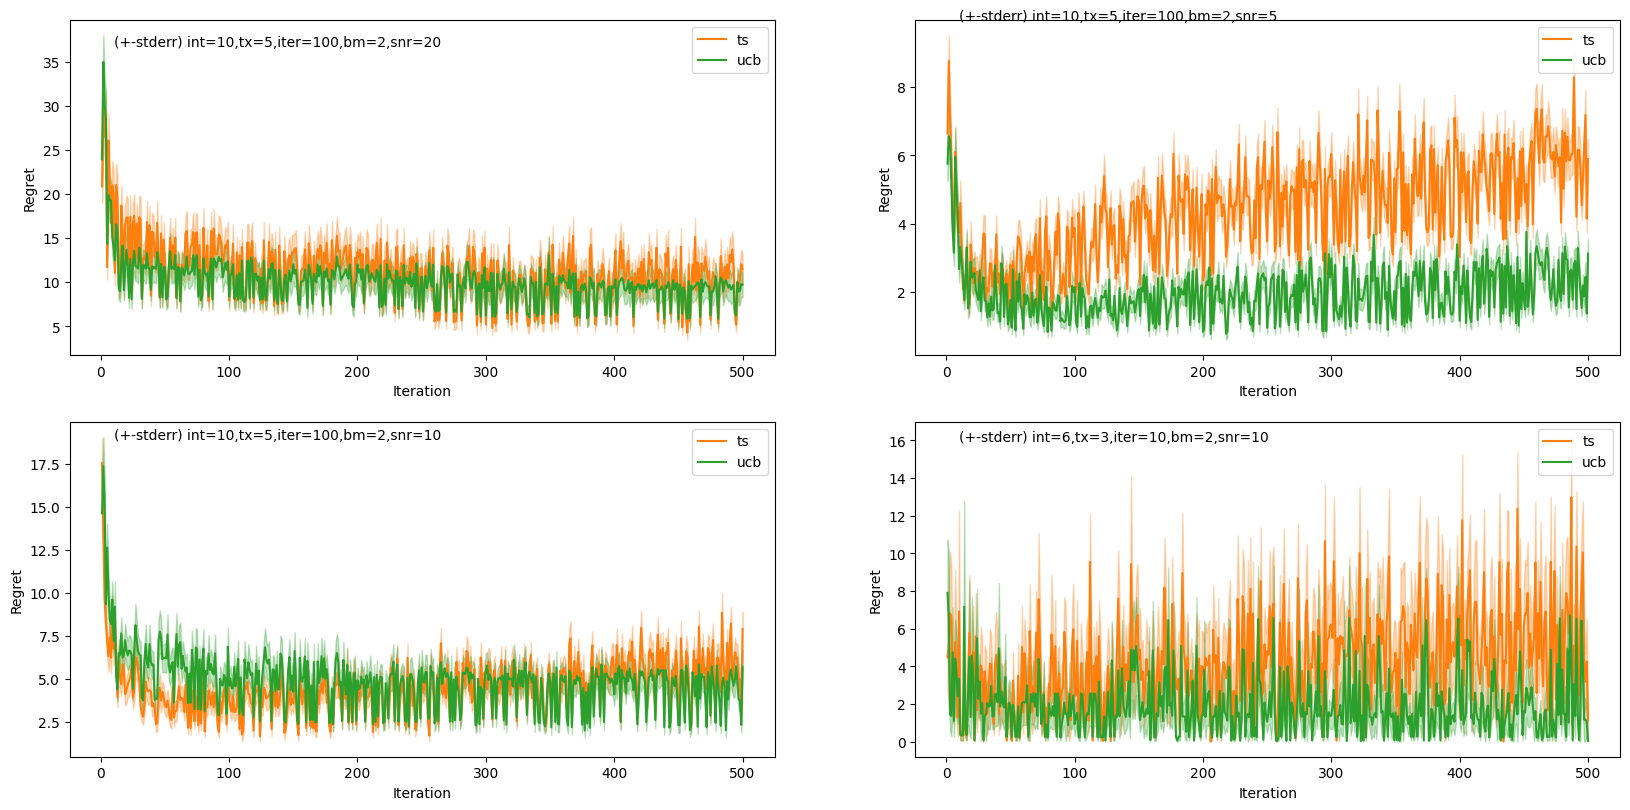

In [179]:
plotrun([1,2,3,4],figsize=(20,20))